# Implementation of the autoencoder

In [1]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils import *

Using TensorFlow backend.


In [2]:
x_train = read_train_images()
x_val = read_validation_images()

/anaconda2/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
y_train = read_train_labels()
y_val = read_validation_labels()

Text(0.5, 1.0, '[1 0]')

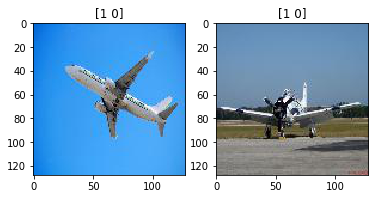

In [5]:
# Display the first image from training data
i=0
plt.subplot(121)
plt.imshow(x_train[i], cmap='gray')
plt.title(y_train[i])

# Display the first image from validation data
plt.subplot(122)
plt.imshow(x_val[i], cmap='gray')
plt.title(y_val[i])

In [6]:
# Conversion of the images to grayscale
x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_train])
x_val_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x_val])

Text(0.5, 1.0, '[1 0]')

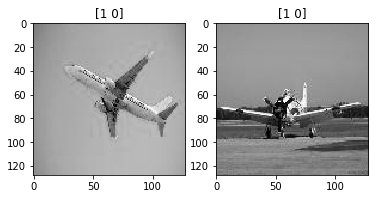

In [8]:
# Display the first image in training data
plt.subplot(121)
plt.imshow(x_train_gray[i], cmap='gray')
plt.title(y_train[i])

# Display the first image in val data
plt.subplot(122)
plt.imshow(x_val_gray[i], cmap='gray')
plt.title(y_val[i])

In [9]:
print("Training set (images) shape: {shape}".format(shape=x_train_gray.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val_gray.shape))

Training set (images) shape: (467, 128, 128)
Validation set (images) shape: (483, 128, 128)


In [10]:
# Verify the training and testing data types -> they should be float32
x_train.dtype, x_val.dtype

(dtype('float32'), dtype('float32'))

In [11]:
# Verify that the training and testing data are normalized
np.max(x_train), np.max(x_val)

(1.0, 1.0)

In [12]:
# Define hyperparameters
batch_size = 32
epochs = 10
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

In [13]:
x_train_gray = np.reshape(x_train_gray,(len(x_train_gray),128,128,1))
x_val_gray = np.reshape(x_val_gray,(len(x_val_gray),128,128,1))

In [14]:
# Defines autoencoder
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded
    

In [15]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
__________

In [ ]:
autoencoder_train = autoencoder.fit(x_train_gray, 
                                    x_train_gray, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val_gray, x_val_gray))


Instructions for updating:
Use tf.cast instead.
Train on 467 samples, validate on 483 samples
Epoch 1/10
467/467 [==============================] - 107s 229ms/step - loss: 0.0800 - val_loss: 0.0245
Epoch 2/10
467/467 [==============================] - 90s 194ms/step - loss: 0.0269 - val_loss: 0.0314
Epoch 3/10
256/467 [===============>..............] - ETA: 33s - loss: 0.0221

In [ ]:
# Calculate the loss
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
output = autoencoder.predict(x_val_gray)

In [ ]:
output_reshaped = np.reshape(output,(len(x_val_gray),128,128))
x_val_reshaped = np.reshape(x_val_gray,(len(x_val_gray),128,128))

In [ ]:
i = 1
plt.subplot(121)
plt.title('Original image')
plt.imshow(x_val_reshaped[i], cmap='gray')
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_reshaped[i], cmap='gray')